In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.neighbors import KernelDensity

## Task 1

### Generate sample

In [20]:
n = 200
k = 0.2

In [21]:
x = 0.9 * np.random.normal(loc=5, scale=1, size=n) + 0.1 * np.random.normal(loc=10, scale=1, size=n)
x_quantile = np.linspace(0, 15, n + 1)

#### Theoretical density function

In [22]:
const = 1 / ((2 * np.pi) ** (1/2))     
normal = lambda x, miu: const * np.exp(-0.5 * ((x - miu) ** 2))
mixture_normal = lambda x: 0.9 * normal(x, 5) + 0.1 * normal(x, 10)

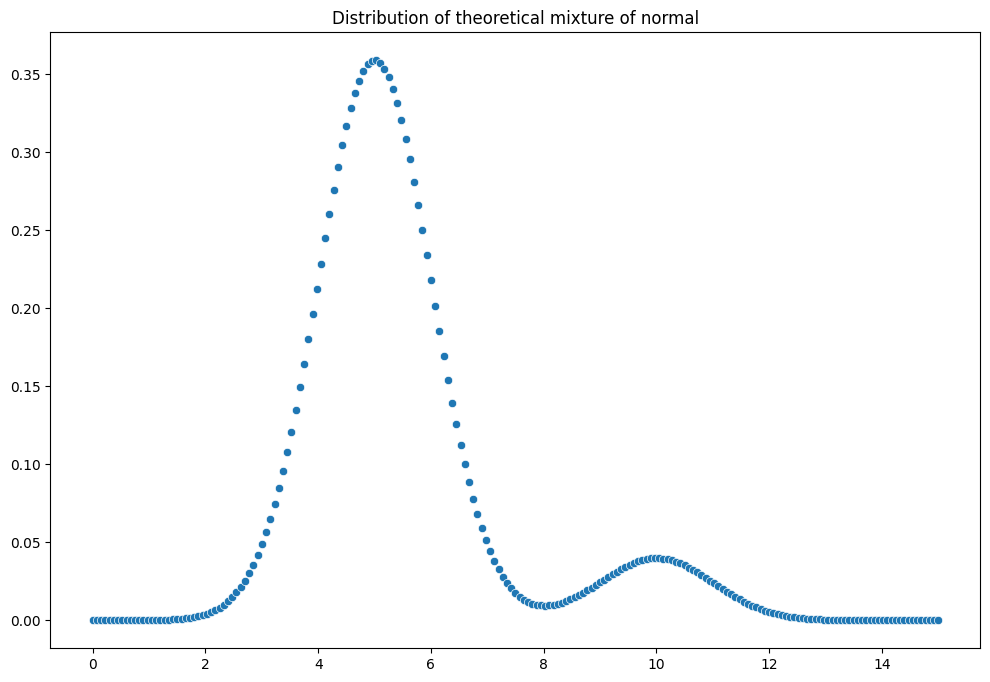

In [23]:
y = []

for el in x_quantile:
    y.append(mixture_normal(el))

plt.figure(figsize=(12, 8))

f = sns.scatterplot(x=x_quantile, y=y)

plt.title("Distribution of theoretical mixture of normal")
plt.show()


In [24]:
x_quantile = np.array(x_quantile).reshape(-1, 1)
x = np.array(x).reshape(-1, 1)

#### Empirical density function

In [25]:
kde = KernelDensity(kernel='gaussian', bandwidth=k).fit(x)

f_theoretical = mixture_normal(x_quantile)
f_empirical = np.exp(kde.score_samples(x_quantile))

x = x.reshape(1, -1)[0]
x_quantile = x_quantile.reshape(1, -1)[0]
f_theoretical = f_theoretical.reshape(1, -1)[0]

In [26]:
print(f"MSE for n = 200:   {mean_squared_error(f_theoretical, f_empirical)}")

MSE for n = 200:   0.0035346015714107725


C:\Users\Maaco\AppData\Local\Temp\ipykernel_10920\1366553329.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(x=x, label='Sample')


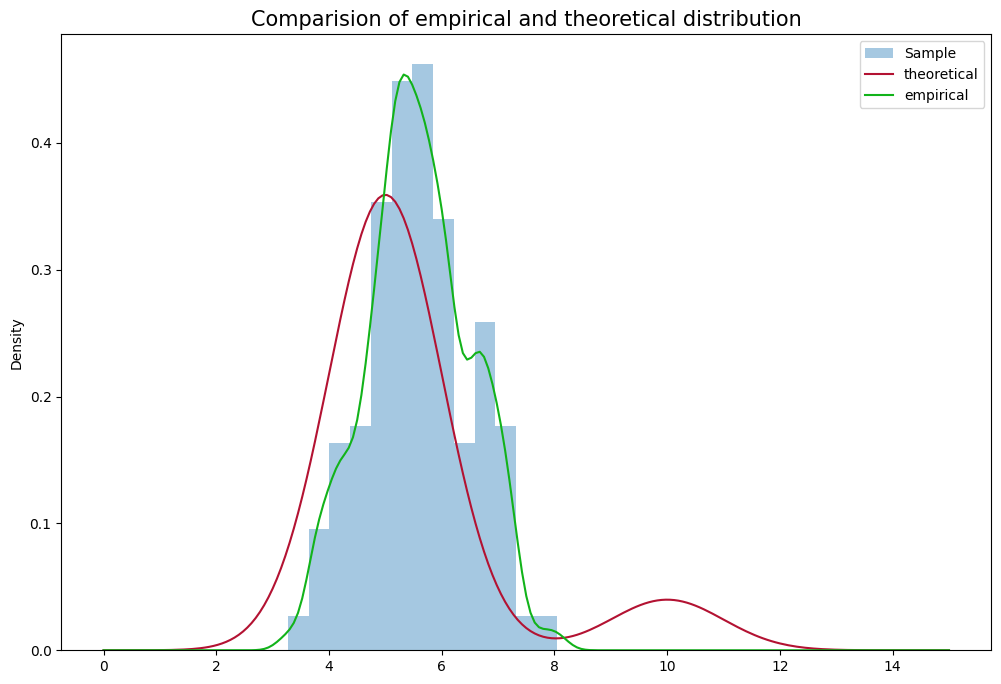

In [27]:
plt.figure(figsize=(12, 8))

ax = sns.distplot(x=x, label='Sample')
ax.get_lines()[0].remove()
ax = sns.lineplot(x=x_quantile, y=f_theoretical, color="#b31232", label='theoretical')
ax = sns.lineplot(x=x_quantile, y=f_empirical, color="#12b31a", label='empirical')

plt.title("Comparision of empirical and theoretical distribution", fontsize=15)

plt.show()

### Experiment for different n

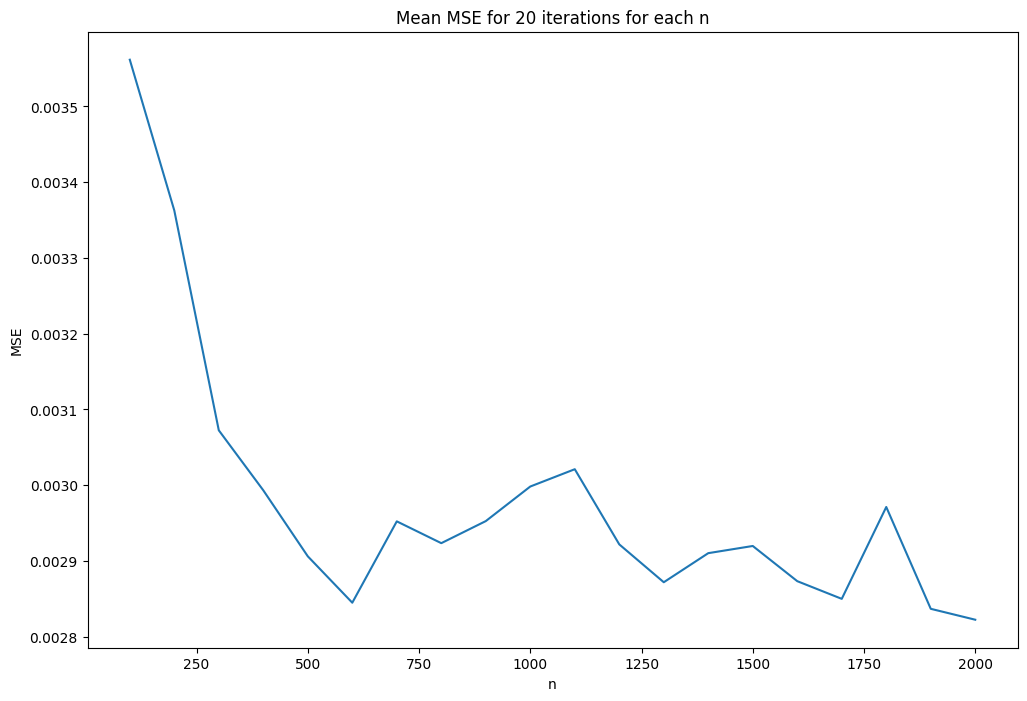

In [28]:
iters = 20
k = 0.2
ns = np.linspace(100, 2000, 20, dtype=int)
mses = []

for n in ns:
    mses_tmp = []
    for i in range(iters):
        x = (0.9 * np.random.normal(loc=5, scale=1, size=n) + 0.1 * np.random.normal(loc=10, scale=1, size=n)).reshape(-1, 1)
        x_quantile = np.linspace(0, 15, n).reshape(-1, 1)

        kde = KernelDensity(kernel='gaussian', bandwidth=k).fit(x)
        f_theoretical = mixture_normal(x_quantile)
        f_empirical = np.exp(kde.score_samples(x_quantile))

        x = x.reshape(1, -1)[0]
        x_quantile = x_quantile.reshape(1, -1)[0]
        f_theoretical = f_theoretical.reshape(1, -1)[0]
        mses_tmp.append(mean_squared_error(f_theoretical, f_empirical))

    mses.append(np.mean(mses_tmp))

plt.figure(figsize=(12, 8))
f = sns.lineplot(x=ns, y=mses)

plt.title("Mean MSE for 20 iterations for each n")
plt.xlabel("n")
plt.ylabel("MSE")

plt.show()

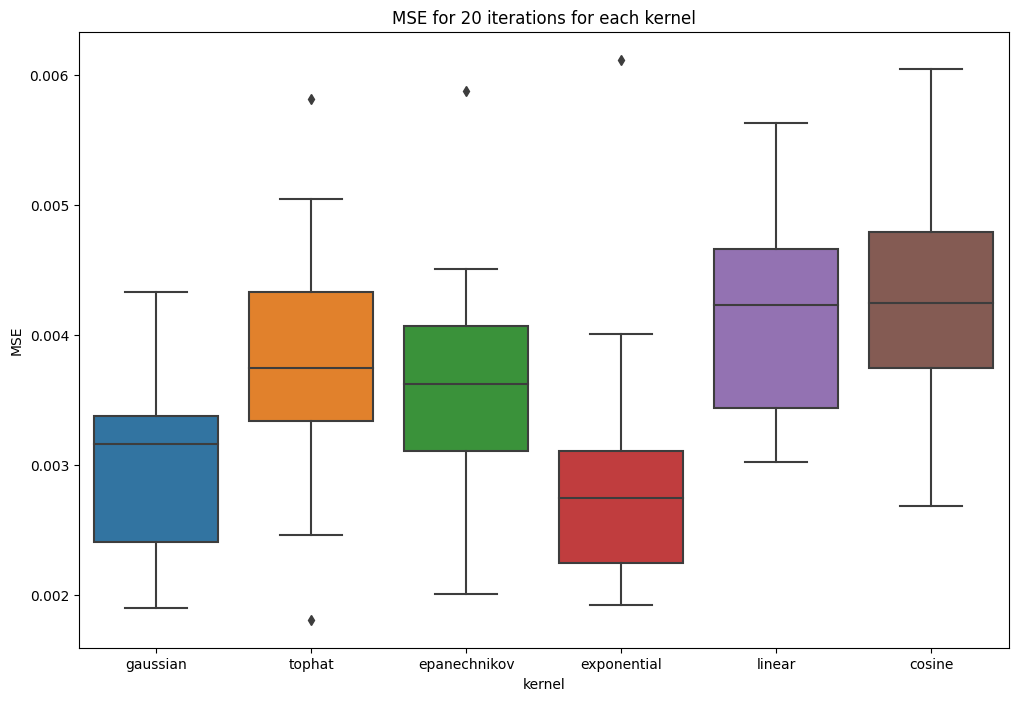

In [29]:
iters = 20
n = 200
k = 0.2
kernels = ["gaussian", "tophat", "epanechnikov", "exponential", "linear", "cosine"]
mses = []

for kernel in kernels:
    mses_tmp = []
    for i in range(iters):
        x = (0.9 * np.random.normal(loc=5, scale=1, size=n) + 0.1 * np.random.normal(loc=10, scale=1, size=n)).reshape(-1, 1)
        x_quantile = np.linspace(0, 15, n).reshape(-1, 1)

        kde = KernelDensity(kernel=kernel, bandwidth=k).fit(x)
        f_theoretical = mixture_normal(x_quantile)
        f_empirical = np.exp(kde.score_samples(x_quantile))

        x = x.reshape(1, -1)[0]
        x_quantile = x_quantile.reshape(1, -1)[0]
        f_theoretical = f_theoretical.reshape(1, -1)[0]
        mses_tmp.append(mean_squared_error(f_theoretical, f_empirical))

    mses.append(mses_tmp)

df = pd.DataFrame(
    data=np.array(mses).T.tolist(),
    columns=kernels
)

plt.figure(figsize=(12, 8))
f = sns.boxplot(data=df)

plt.title("MSE for 20 iterations for each kernel")
plt.xlabel("kernel")
plt.ylabel("MSE")

plt.show()

## Naive Bayes

In [30]:
df = pd.read_csv("haberman.data", header=None)

X = df.drop(columns=[3], axis=1)
y = df[3]

In [44]:
class NB:
    def __init__(self):
        self.prior_probabilities = {}
        self.means = []
        self.variance = []
        self.KDE = {}
    
    def fit(self,X,y):
        self.prior_probabilities[0] = sum([1 if j == 1 else 0 for j in y])/len(y)
        self.prior_probabilities[1] = sum([1 if j == 2 else 0 for j in y])/len(y)

        df = pd.DataFrame(X)
        df['y'] = y
        X_0 = df[df['y']==1][[0,1]]
        xx = np.array(X_0[0])
        xx = xx[:, np.newaxis]
        xx1 = np.array(X_0[1])
        xx1 = xx1[:, np.newaxis]
        kde = KernelDensity(bandwidth=0.2).fit(xx)
        self.KDE[0]= kde.score_samples(xx)
        self.KDE[1]= kde.score_samples(xx1)
        
    def predict_proba(self,Xtest):
        probas = []
        p_0 = []
        for _, row in Xtest.iterrows():
            p_0_j = []
            for i in range (len(row)):
                j = self.KDE[0][i] * self.KDE[1][i] * self.prior_probabilities[0]
                p_0_j.append(j)
            p_0 = np.prod(p_0_j)
            probas.append(p_0)

        return probas           
           
    def predict(self,Xtest):
        predictions = []
        probas  = self.predict_proba(Xtest)
        for p in probas:
            if p > 0.5:
                predictions.append(1)
            else:
                predictions.append(0)
        
        return predictions
    
    def get_params(self):
        return [ 
            self.prior_probabilities, 
            self.means, 
            self.covariance,
        ]

In [45]:
iterations = 100

accs = [[], [], [], []]

for i in range(iterations):
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

        X_train_cat = X_train.apply(lambda x: pd.Categorical(x), axis=0)
        X_test_cat = X_test.apply(lambda x: pd.Categorical(x), axis=0)

        lda = LinearDiscriminantAnalysis()
        gnb = GaussianNB()
        cnb = CategoricalNB()
        nb = NB()

        lda.fit(X_train, y_train)
        gnb.fit(X_train, y_train)
        cnb.fit(X_train_cat, y_train)
        nb.fit(X_train, y_train)

        y_pred_lda = lda.predict(X_test)
        y_pred_gnb = gnb.predict(X_test)
        y_pred_cnb = cnb.predict(X_test_cat)
        y_pred_nb = nb.predict(X_test)

        accs[0].append(accuracy_score(y_test, y_pred_lda))
        accs[1].append(accuracy_score(y_test, y_pred_gnb))
        accs[2].append(accuracy_score(y_test, y_pred_cnb))
        accs[3].append(accuracy_score(y_test, y_pred_nb))


    except IndexError:
        continue

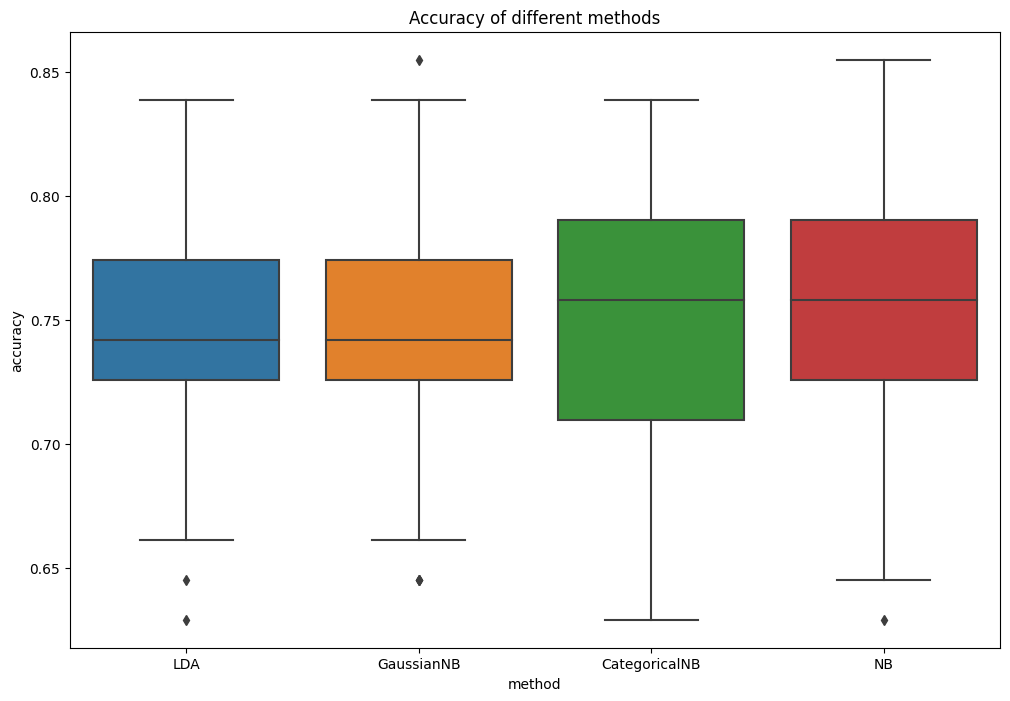

In [46]:
df = pd.DataFrame(
    data=np.array(accs).T.tolist(),
    columns=["LDA", "GaussianNB", "CategoricalNB", "NB"]
)

plt.figure(figsize=(12, 8))
f = sns.boxplot(data=df)

plt.title("Accuracy of different methods")
plt.xlabel("method")
plt.ylabel("accuracy")

plt.show()